# OpenVINO Demo: Loading Multiple Networks

### Let's figure out how to do inference on multiple networks in sequence!

This demo basically shows how to load multiple networks into OpenVINO's IENetwork/IEPlugin and use the output from one network for the input of the other network in order to get the result we want.

**As a bonus, we will go over how to reshape a network's input layer and check if a plugin supports our layers. Note also that this will not work with the Intel NCS 2 due to limited memory resources.**

First, let's import what we need.

In [2]:
import cv2
import numpy as np
from openvino.inference_engine import IENetwork, IECore
import time

OS = 'windows'
dev = 'CPU'
ie = IECore()

Loading our first network...

In [3]:
path_to_objxml = 'gesture_optimized\\fp32\\frozen_inference_graph.xml'
path_to_objbin = 'gesture_optimized\\fp32\\frozen_inference_graph.bin'

obj_net = IENetwork(model=path_to_objxml, weights=path_to_objbin)

In [4]:
# Analysis of input/output
print(obj_net.inputs)
print(obj_net.outputs)

{'image_tensor': <openvino.inference_engine.ie_api.InputInfo object at 0x000002AE9F7C2990>}
{'DetectionOutput': <openvino.inference_engine.ie_api.OutputInfo object at 0x000002AEA691F030>}


Pre-processing our data...

In [5]:
n, c, h, w = obj_net.inputs['image_tensor'].shape
obj_frame = cv2.imread("./hand_test_images\hand_test3.jpg")
obj_in_frame = cv2.resize(obj_frame, (w, h))
obj_in_frame = obj_in_frame.transpose((2, 0, 1))
obj_in_frame = obj_in_frame.reshape((n, c, h, w))

Loading our first network into Core...

In [6]:
ext = None
if OS.lower() == 'windows':
    ext = 'C:\\Users\\freyes\\Documents\\Intel\\OpenVINO\\inference_engine_samples_build\\intel64\\Release\\cpu_extension.dll'
else:
    ext = '/opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so'

if dev.lower() == 'cpu':
    ie.add_extension(ext, device_name=dev)
obj_exec_net = ie.load_network(network=obj_net, device_name=dev, num_requests=1)
obj_exec_net

Running infernce...

In [7]:
import matplotlib.pyplot as plt

obj_res = obj_exec_net.infer({'image_tensor': obj_in_frame})
obj_det = obj_res['DetectionOutput']
obj_det.shape, obj_frame.shape

((1, 1, 100, 7), (720, 1280, 3))

Let's post-process our data, but we don't care as much about classification this time.

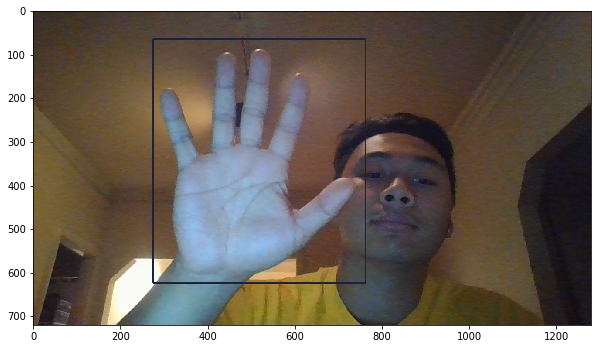

In [8]:
initial_w = obj_frame.shape[1]
initial_h = obj_frame.shape[0]

xmin = ymin = xmax = ymax = 0

for obj in obj_det[0][0]:
    # Draw only objects when probability more than specified threshold
    if obj[2] > 0.5:
        xmin = int(obj[3] * initial_w)
        ymin = int(obj[4] * initial_h)
        xmax = int(obj[5] * initial_w)
        ymax = int(obj[6] * initial_h)
        class_id = int(obj[1])
        # Draw box and label\class_id
        color = (min(class_id * 12.5, 255), min(class_id * 7, 255), min(class_id * 5, 255))
        cv2.rectangle(obj_frame, (xmin, ymin), (xmax, ymax), color, 2)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(obj_frame, cv2.COLOR_BGR2RGB)) 

We are going to constrain our view to only the bounding box's view.

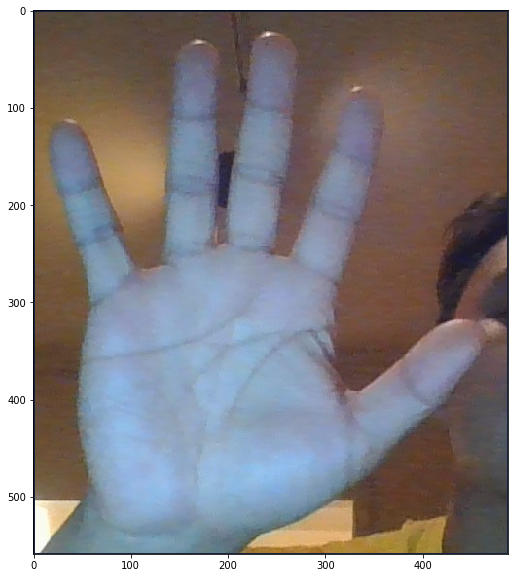

In [9]:
obj_frame = obj_frame[ymin:ymax, xmin:xmax]
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(obj_frame, cv2.COLOR_BGR2RGB)) 

### Time to load the Optimized HandPose Network!

Loading our second network and doing some analysis...

In [22]:
path_to_xmlr = 'handpose_optimized\\fp32\\pose_iter_102000.xml'
path_to_binr = 'handpose_optimized\\fp32\\pose_iter_102000.bin'

# Set up network for inference
handpose_net = IENetwork(model=path_to_xmlr, weights=path_to_binr)

In [23]:
# Understand  input/output
print(handpose_net.inputs)
print(handpose_net.outputs)

{'image': <openvino.inference_engine.ie_api.InputInfo object at 0x000002AE9E3A2A30>}
{'Mconv7_stage6': <openvino.inference_engine.ie_api.OutputInfo object at 0x000002AEABE09300>}


In [24]:
# Get shape of input/output
input_layer = next(iter(handpose_net.inputs))
output_layer = next(iter(handpose_net.outputs))
print('Shape of input: ' + str(handpose_net.inputs[input_layer].shape))
print('Shape of output: ' + str(handpose_net.outputs[output_layer].shape))

Shape of input: [1, 3, 1, 1]
Shape of output: [1, 22, 1, 1]


Here, we will pre-process the constrained frame determined by our first network's detections. This involves resiziing our input to make inference a little bit faster when using our second network.

In [25]:
# Preparing data as blob
frame = obj_frame
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
aspect_ratio = frameWidth / frameHeight

print('Actual Img Dimensions: ' + 
       str((frameWidth, frameHeight, aspect_ratio)))

inHeight = 268
inWidth = int(((aspect_ratio*inHeight)*8)//8)

inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=True, crop=False)
frame = cv2.resize(frame, (inWidth, inHeight))
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
aspect_ratio = frameWidth / frameHeight

print('Resize Img Dimensions: ' + 
       str((frameWidth, frameHeight, aspect_ratio)))
print('Blob Dimensions: ' + str(inpBlob.shape))

Actual Img Dimensions: (488, 559, 0.8729874776386404)
Resize Img Dimensions: (233, 268, 0.8694029850746269)
Blob Dimensions: (1, 3, 268, 233)


Let's reshape the top layer of our second network to accept the dimensions of our input.

In [26]:
# [1, 3, 1, 1] is a problematic shape for our image; need to reshape
n, c, h, w = handpose_net.inputs[input_layer].shape

# Based on prototxt, original input: [2, 3, 368, 368]
handpose_net.reshape({input_layer: (n, c, inHeight, inWidth)})
handpose_net.inputs[input_layer].shape

[1, 3, 268, 233]

We will now load our second network into core.

In [29]:
# Loading network into Core
exec_handpose_net = ie.load_network(network=handpose_net, device_name=dev, num_requests=1)
exec_handpose_net

In [30]:
# Checking supported layers as an intermediate step
layer_mappings = ie.query_network(network=handpose_net, device_name=dev)
layer_mappings

{'Mconv1_stage2': 'CPU',
 'Mconv1_stage3': 'CPU',
 'Mconv1_stage4': 'CPU',
 'Mconv1_stage5': 'CPU',
 'Mconv1_stage6': 'CPU',
 'Mconv2_stage2': 'CPU',
 'Mconv2_stage3': 'CPU',
 'Mconv2_stage4': 'CPU',
 'Mconv2_stage5': 'CPU',
 'Mconv2_stage6': 'CPU',
 'Mconv3_stage2': 'CPU',
 'Mconv3_stage3': 'CPU',
 'Mconv3_stage4': 'CPU',
 'Mconv3_stage5': 'CPU',
 'Mconv3_stage6': 'CPU',
 'Mconv4_stage2': 'CPU',
 'Mconv4_stage3': 'CPU',
 'Mconv4_stage4': 'CPU',
 'Mconv4_stage5': 'CPU',
 'Mconv4_stage6': 'CPU',
 'Mconv5_stage2': 'CPU',
 'Mconv5_stage3': 'CPU',
 'Mconv5_stage4': 'CPU',
 'Mconv5_stage5': 'CPU',
 'Mconv5_stage6': 'CPU',
 'Mconv6_stage2': 'CPU',
 'Mconv6_stage3': 'CPU',
 'Mconv6_stage4': 'CPU',
 'Mconv6_stage5': 'CPU',
 'Mconv6_stage6': 'CPU',
 'Mconv7_stage2': 'CPU',
 'Mconv7_stage3': 'CPU',
 'Mconv7_stage4': 'CPU',
 'Mconv7_stage5': 'CPU',
 'Mconv7_stage6': 'CPU',
 'Mrelu1_2_stage2_1': 'CPU',
 'Mrelu1_2_stage3_1': 'CPU',
 'Mrelu1_2_stage4_1': 'CPU',
 'Mrelu1_2_stage5_1': 'CPU',
 'Mrelu1_

Running inference on the second network using our resized input...

In [31]:
t = time.time()
res = exec_handpose_net.infer({'image': inpBlob})
print("time taken by network : {:.3f}".format(time.time() - t))

time taken by network : 1.129


For this network, we are going to do some intermediate analysis of the output data to better understand it. Essentially, HandPose's output assings detection probability to pixels on the input frame. High probability at a pixel is an indication of a hand keypoint at that pixel.

In [32]:
# Processing output
import matplotlib.pyplot as plt
%matplotlib inline

output = res[output_layer]

print(output.shape)
print(frame.shape)

(1, 22, 34, 30)
(268, 233, 3)


We will generate this probability map for illustration.

c:\users\freyes\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


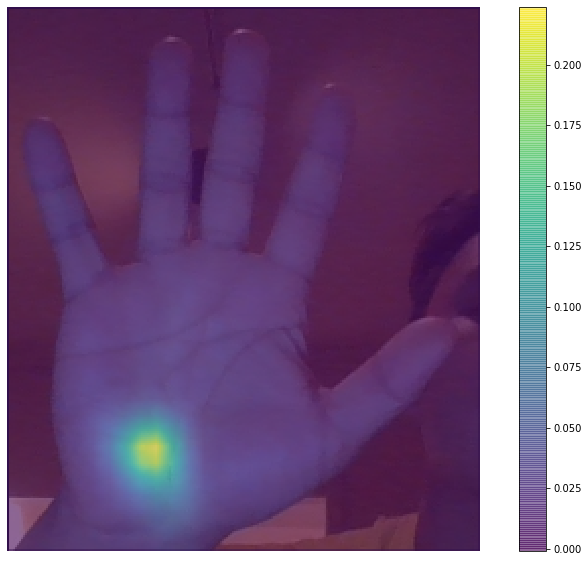

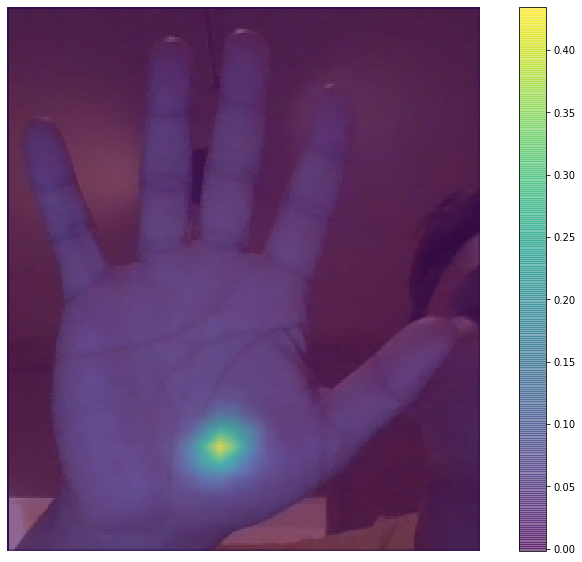

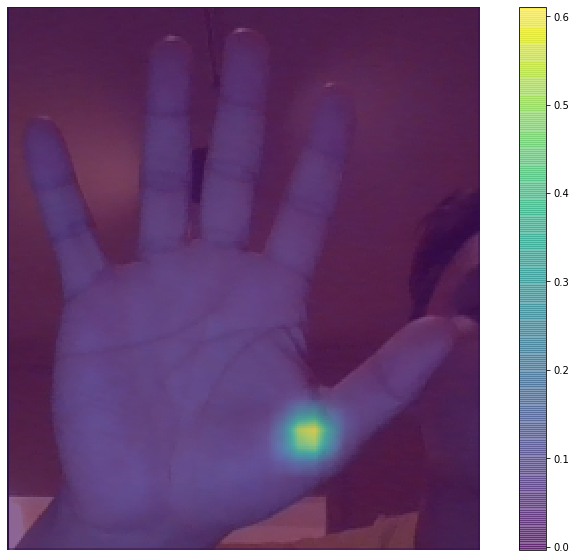

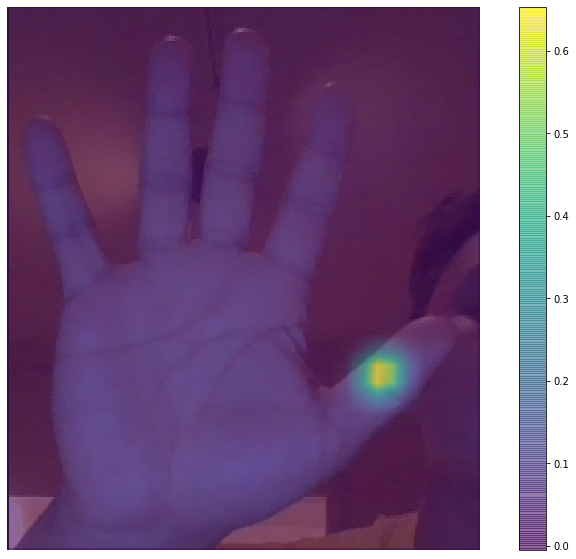

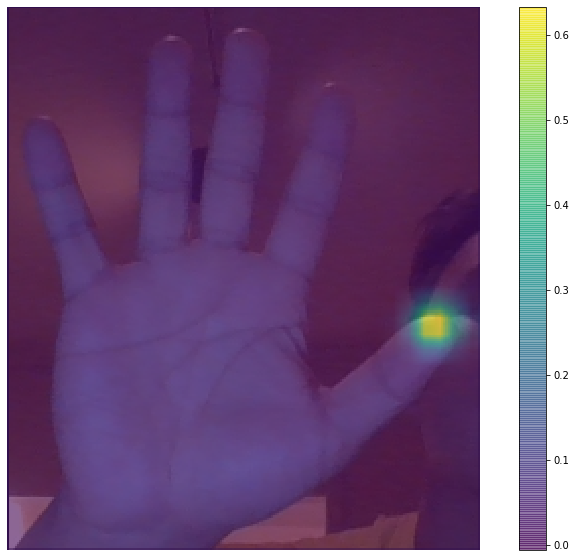

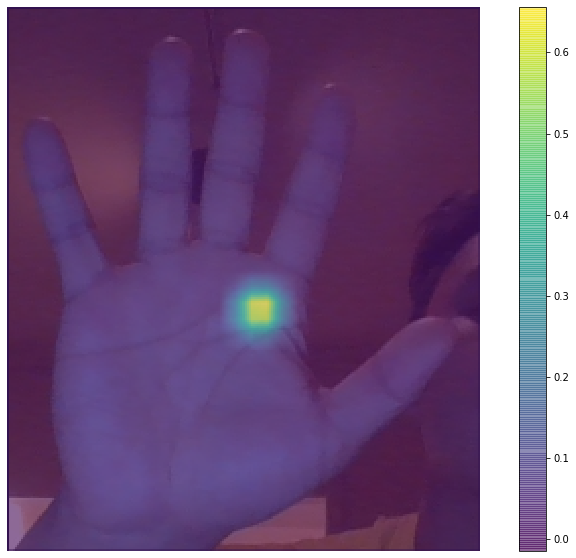

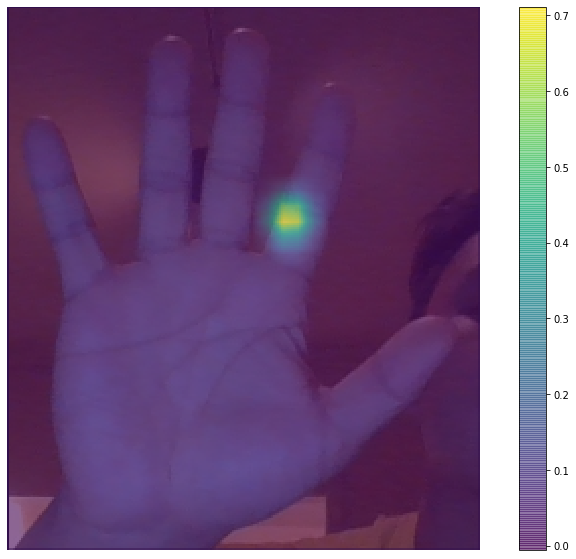

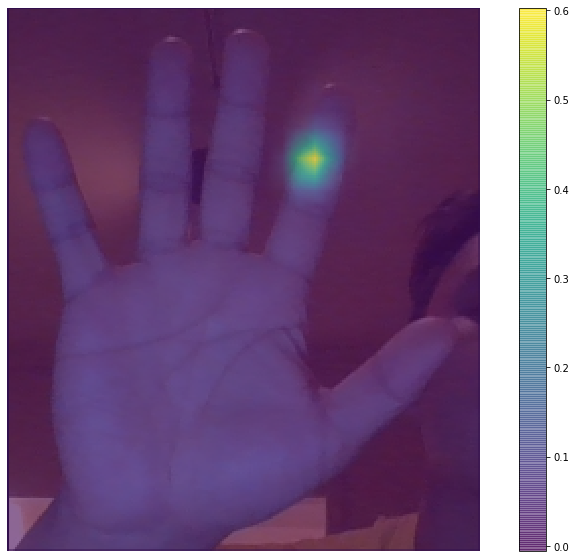

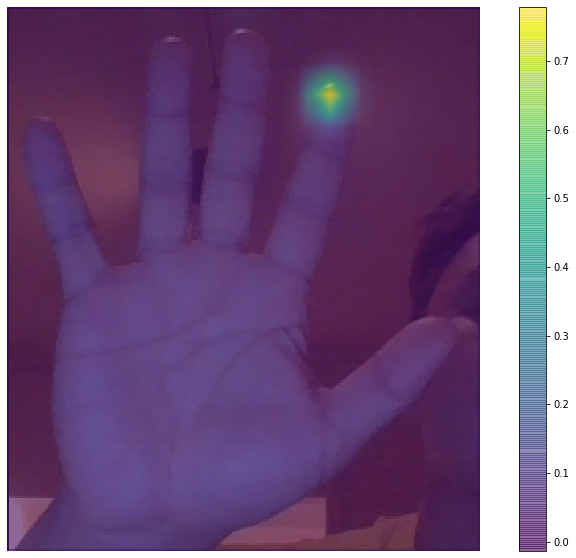

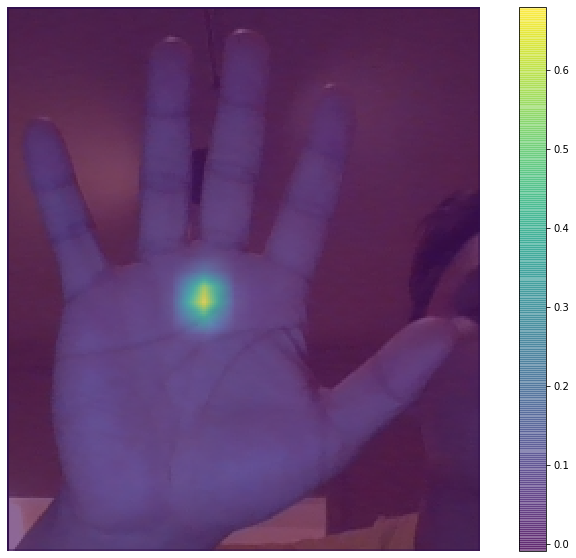

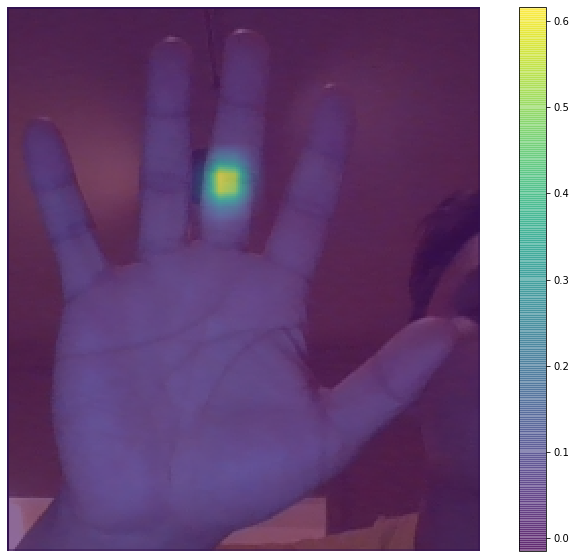

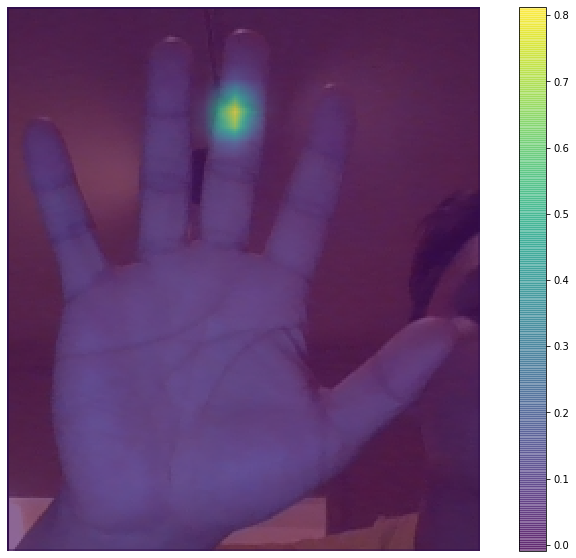

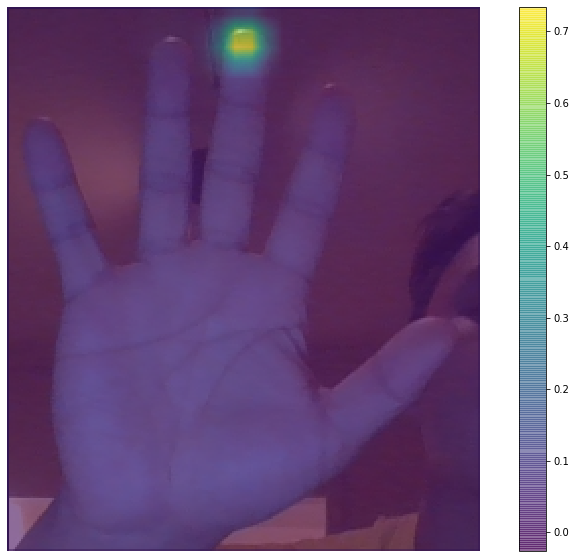

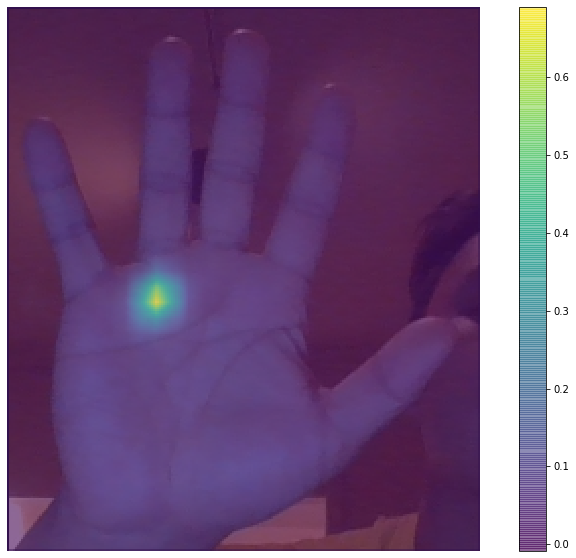

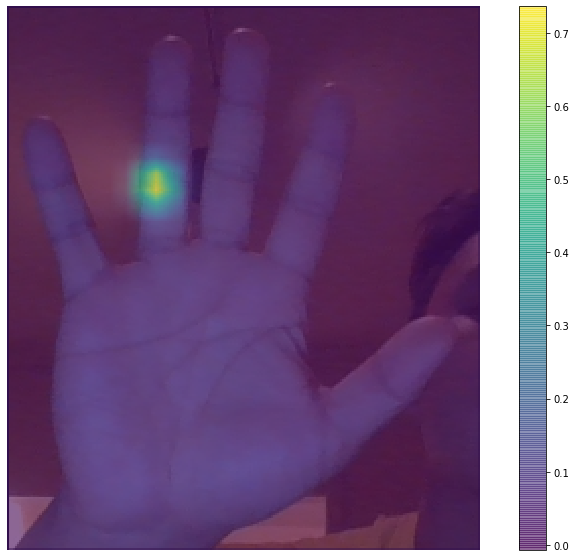

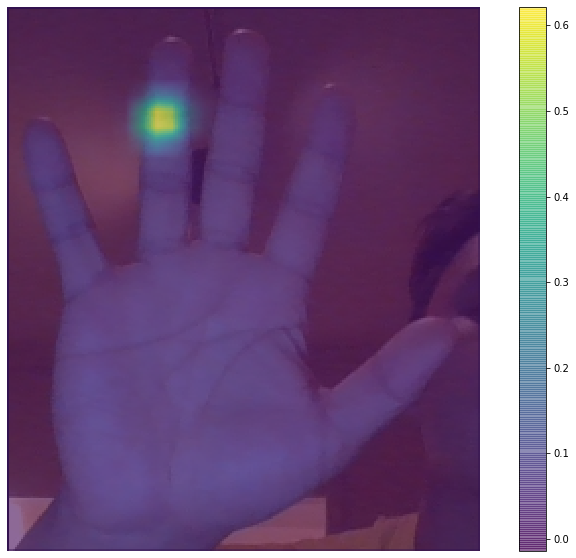

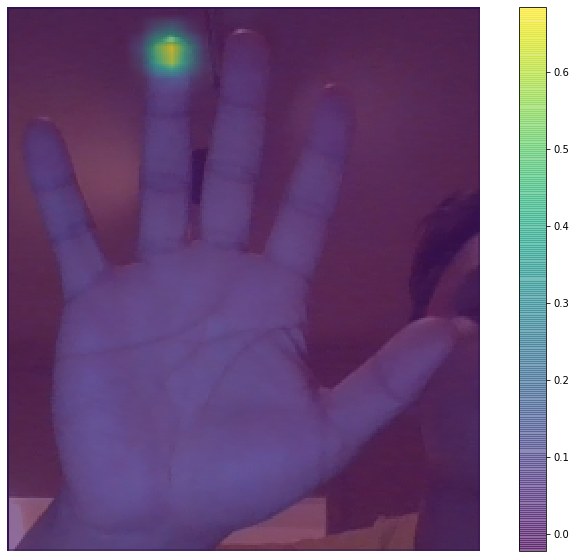

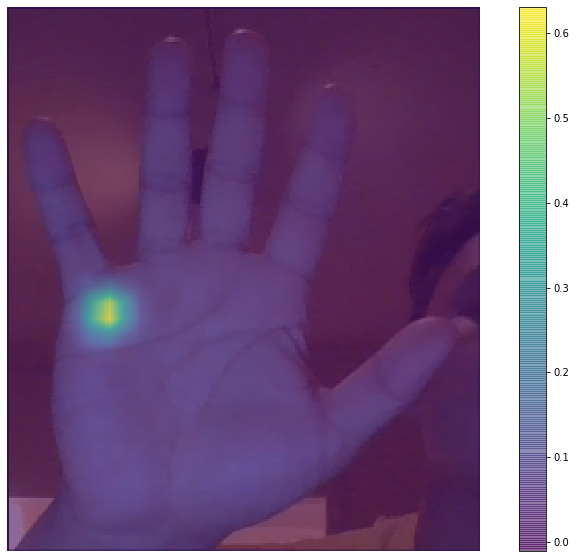

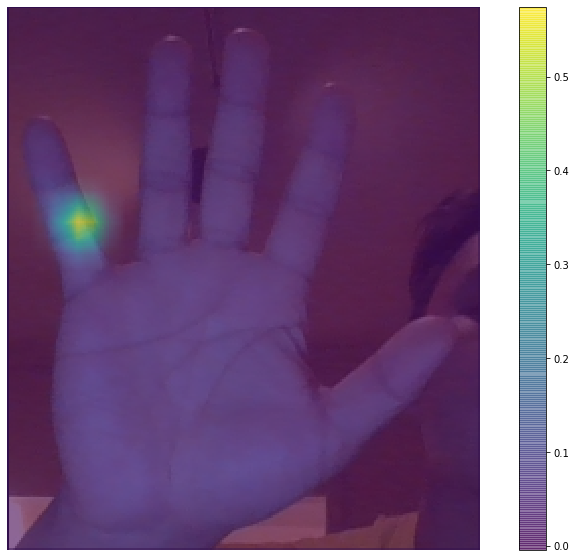

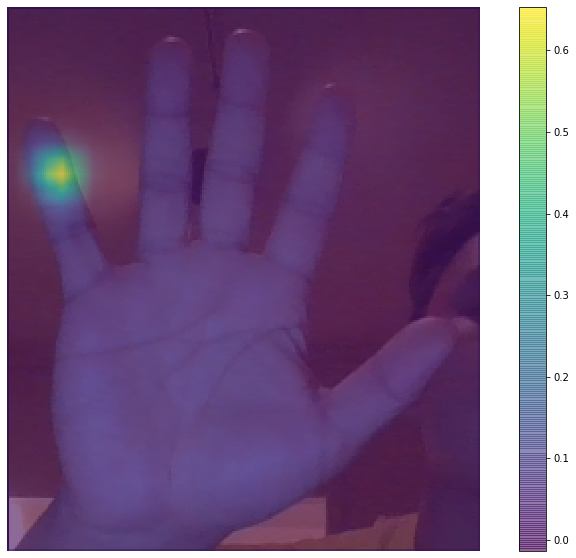

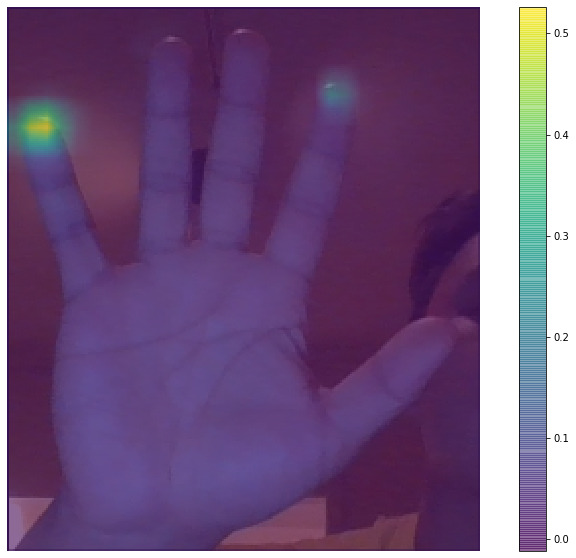

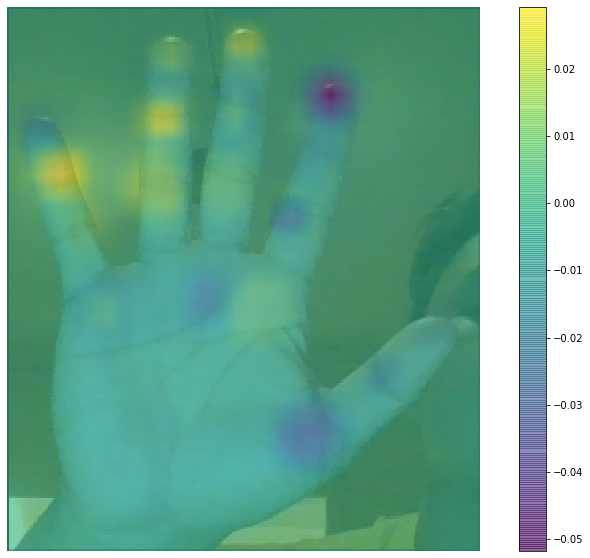

In [33]:
for i in range(22):
    probMap = output[0, i, :, :]
    probMap = cv2.resize(probMap, (frame.shape[1], frame.shape[0]))
    plt.figure(figsize=[14,10])
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.imshow(probMap, alpha=0.6)
    plt.colorbar()
    plt.axis("off")

Finally, let's translate the probability map to keypoints that we render on our input frame!

0: (73, 217)
1: (104, 216)
2: (151, 209)
3: (182, 184)
4: (213, 154)
5: (127, 146)
6: (136, 106)
7: (151, 74)
8: (159, 43)
9: (97, 145)
10: (105, 83)
11: (112, 51)
12: (113, 19)
13: (73, 145)
14: (73, 90)
15: (74, 58)
16: (81, 20)
17: (50, 153)
18: (35, 106)
19: (27, 82)
20: (19, 59)
21: (27, 82)
Points Detected: 22


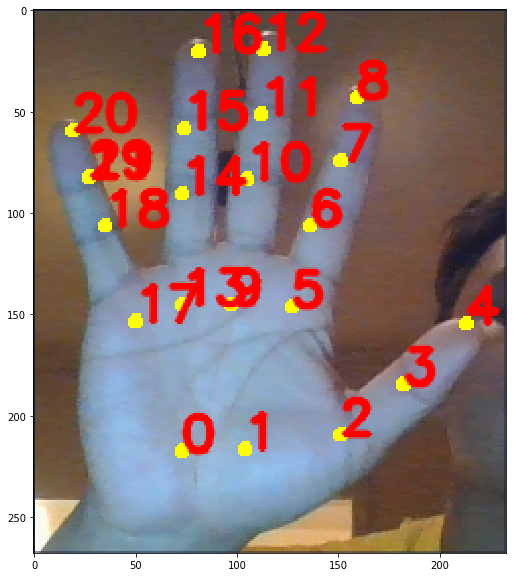

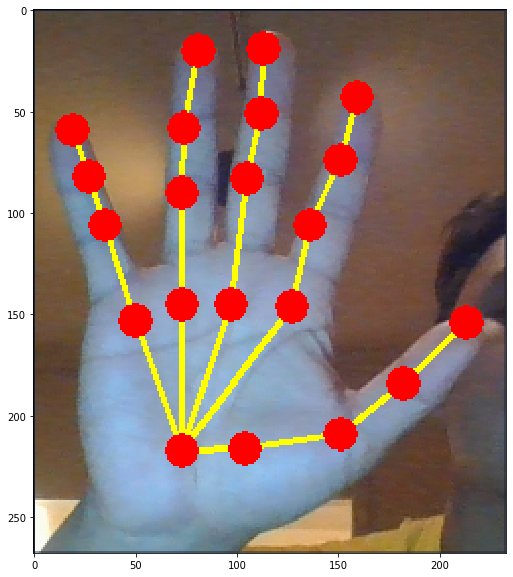

In [35]:
nPoints = 22
POSE_PAIRS = [[0,1],[1,2],[2,3],[3,4],[0,5],[5,6],[6,7],[7,8],[0,9],[9,10],[10,11],[11,12],[0,13],[13,14],[14,15],[15,16],[0,17],[17,18],[18,19],[19,20]]

points = []
threshold = 0.01

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]
    probMap = cv2.resize(probMap, (inWidth, inHeight))

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

    if prob > threshold :
        print(str(i) + ": " + str((int(point[0]), int(point[1]))))
        cv2.circle(frameCopy, (int(point[0]), int(point[1])), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 255), 2, lineType=cv2.LINE_AA)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(point[0]), int(point[1])))
    else :
        points.append(None)

actual_points = [x for x in points if x != None]
print("Points Detected: " + str(len(actual_points)))

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 2)
        cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.circle(frame, points[partB], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))      

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


# Congratulations! You now know how to load multiple networks!